<a href="https://colab.research.google.com/github/Fandi16/bisindo/blob/main/bismillah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import random
from random import sample
import numpy as np
import itertools
import skimage
from PIL import Image
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
 # Menentukan direktori pelatihan dan pengujian
TRAINING_DIR_BISINDO = '/content/drive/MyDrive/DatasetBISINDO/datatrain'
TEST_DIR_BISINDO = '/content/drive/MyDrive/DatasetBISINDO/val'

In [ ]:
# Memastikan GPU tersedia
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    angle = random.randint(0, 182)  # Perbaikan pada penulisan variabel 'angle' dan rentang random
    return rotate(img, angle)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    angle = random.randint(0, 180)  # Perbaikan pada penulisan variabel 'angle' dan rentang random
    return rotate(img, -angle)

# Membuat fungsi untuk melakukan flip gambar atas dan bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek terang pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = adjust_gamma(img, gamma=0.5, gain=1)  # Perbaikan pada penulisan parameter 'gamma'
    return img
# Membuat fungsi untuk memberikan efek blur/buram pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return cv2.GaussianBlur(img, (9, 9), 0)  # Perbaikan pada penulisan cv2.GaussianBlur

# Membuat fungsi untuk memberikan efek sheared pada gambar
def sheared(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    transform = AffineTransform(shear=0.2)  # Perbaikan pada penulisan AffineTransform
    sheared_image = warp(img, transform, mode="wrap")
    return sheared_image

# Membuat fungsi untuk melakukan pergeseran melengkung, dewarp_shift
def dewarp_shift(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    transform = AffineTransform(translation=(0, 48))  # Perbaikan pada penulisan AffineTransform
    warp_image = warp(img, transform, mode="wrap")
    return warp_image


In [ ]:
transformations = {
    "rotate anticlockwise": anticlockwise_rotation,
    "rotate clockwise": clockwise_rotation,
    "warp shift": dewarp_shift,
    "blurring image": blur_image,
    "add brightness": add_brightness,
    "flip up down": flip_up_down,
    "shear image": sheared
}

images_path = "dataset/train/Z"  # Path untuk gambar original
augmented_path = "dataset/train/Z"
images = []  # Untuk menyimpan gambar yang telah diproses preprocessing dari folder
for im in os.listdir(images_path):
    # Baca nama gambar dari folder dan tambahkan path ke dalam array images
    images.append(os.path.join(images_path, im))

images_to_generate = 150# Jumlah gambar yang akan ditambah dengan hasil transformasi augmentasi, jumlah disesuaikan kebutuhan
i = 1
# Variabel untuk diulangi hingga jumlah images to generate yang telah ditentukan
while i <= images_to_generate:
    image = random.choice(images)
    original_image = io.imread(image)
    transformed_image = None
    # Variabel untuk diulang hingga jumlah transformasi yang akan diterapkan
    n = 0
    transformation_count = random.randint(1, len(transformations))
    while n < transformation_count:
        key = random.choice(list(transformations))
        transformed_image = transformations[key](original_image)
        n += 1
    new_image_path = "%s/augmented_image_%s.jpg" %(augmented_path,i)
    transformed_image = img_as_ubyte(transformed_image)  # Mengkonversi gambar ke format byte tidak bertanda
    cv2.imwrite(new_image_path, transformed_image)
    i =i+1

In [ ]:
data_generator_BISINDO = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_BISINDO = data_generator_BISINDO.flow_from_directory(TRAINING_DIR_BISINDO,
                                                                target_size=(224,224),
                                                                shuffle=True,
                                                                class_mode='categorical',
                                                                batch_size=64,
                                                                subset="training"
                                                                )

validation_generator_BISINDO = data_generator_BISINDO.flow_from_directory(TRAINING_DIR_BISINDO,
                                                                     target_size=(224,224),
                                                                     shuffle=False,
                                                                     class_mode='categorical',
                                                                     batch_size=64,
                                                                     subset="validation"
                                                                     )


Found 8738 images belonging to 26 classes.
Found 2167 images belonging to 26 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Memuat model MobileNetV2 tanpa top layer
pretrained_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
# Menambahkan lapisan kustom di atas model pretrained
x = GlobalAveragePooling2D()(pretrained_model.output)
x = Dense(1024, activation="relu", name="dense_1")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu", name="dense_2")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu", name="dense_3")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu", name="dense_4")(x)
x = Dropout(0.3)(x)
predictions = Dense(26, activation="softmax", name="output")(x)

# Membuat model baru
model = Model(inputs=pretrained_model.input, outputs=predictions)

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
from tensorflow.keras.callbacks import Callback

# create custom callback
class CustomCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.97:
      print('Accuracy above 95% -- Stop Training')
      self.model.stop_training = True # Stop model training

my_callback = CustomCallback()

In [ ]:
history = model.fit(
    train_generator_BISINDO,
    steps_per_epoch=np.ceil(train_generator_BISINDO.samples / 64),
    epochs=50,
    validation_data=validation_generator_BISINDO,
    validation_steps=np.ceil(validation_generator_BISINDO.samples / 64),
    callbacks=[my_callback]
)

Epoch 1/50
 19/137 [===>..........................] - ETA: 29:47 - loss: 3.4772 - accuracy: 0.0535

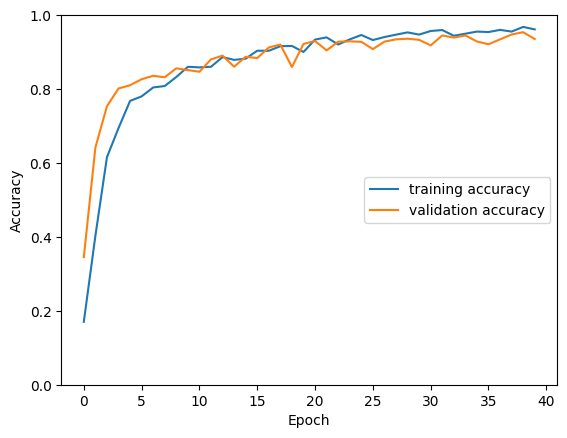

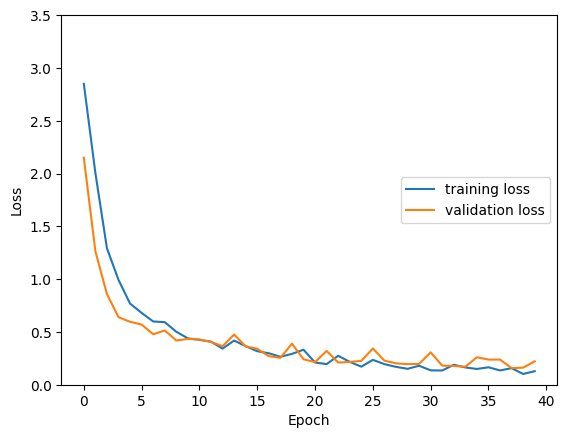

In [ ]:
import pandas as pd
# Menyimpan history pelatihan
pd.DataFrame(history.history).to_csv('history.csv')

# Memvisualisasikan metrik akurasi selama pelatihan
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0., 1])
plt.legend(loc='right')
plt.savefig('train_val_acc_augmentation.png')
plt.show()

# Memvisualisasikan metrik loss selama pelatihan
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0., 3.5])
plt.legend(loc='right')
plt.savefig('train_val_loss_augmentation.png')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)  # Perbaikan pada rotasi label sumbu x
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


[INFO] Testing and evaluating...
72/72 [==============================] - 106s 1s/step - loss: 0.2191 - accuracy: 0.9361
[INFO] Train accuracy: 98.00%
[INFO] Train loss: 0.05836579576134682
[INFO] Validation accuracy: 93.61%
[INFO] Validation loss: 0.2191035896539688
72/72 [==============================] - 103s 1s/step
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
              precision    recall  f1-score   support

           A       0.98      0.98      0.98        88
           B       0.93      0.97      0.95        88
           C       1.00      0.91      0.95        86
           D       0.86      0.99      0.92        87
           E       0.99      1.00      0.99        89
           F       0.97      0.93      0.95        90
           G       0.94      1.00      0.97        90
           H       0.98      0.92      0.95        87
           I       0.99      0.82      0.90        90
      

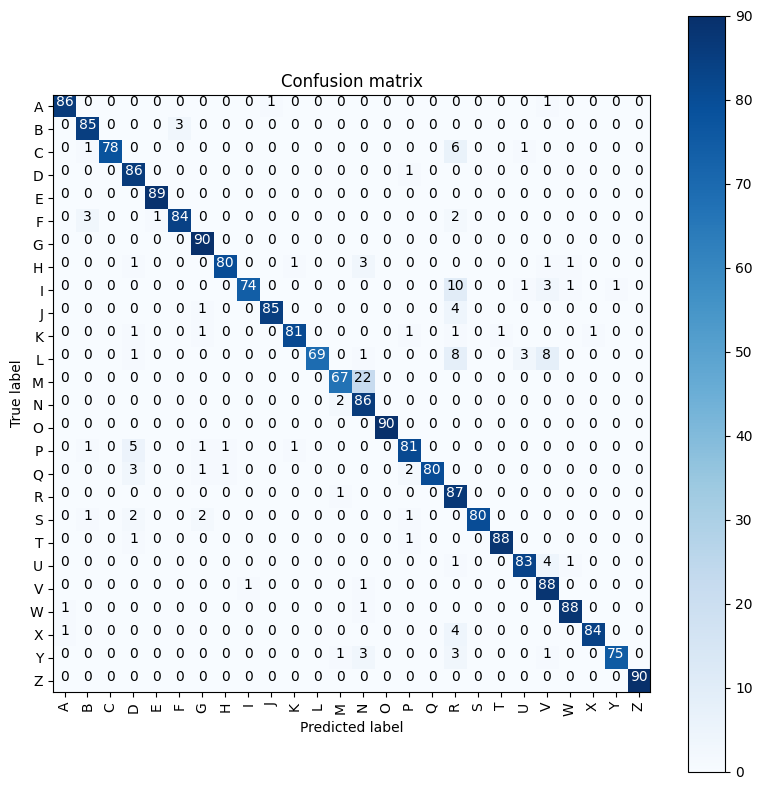

In [ ]:
print("[INFO] Testing and evaluating...")

(eval_loss_train, eval_accuracy_train) =  model.evaluate(train_generator_BISINDO, batch_size=32, verbose=1)
(eval_loss_val, eval_accuracy_val) =  model.evaluate(validation_generator_BISINDO, batch_size=32, verbose=1)

print("[INFO] Train accuracy: {:.2f}%".format(eval_accuracy_train * 100))
print("[INFO] Train loss: {}".format(eval_loss_train))
print("[INFO] Validation accuracy: {:.2f}%".format(eval_accuracy_val * 100))
print("[INFO] Validation loss: {}".format(eval_loss_val))

# Prediksi menggunakan data validation generator
test_preds = model.predict(validation_generator_BISINDO)

# Buat hasil prediksi dalam bentuk numpy argmax
y_pred = np.argmax(test_preds, axis=1)

# Buat variabel true classes, yang akan berisi data kelas sebenarnya
true_classes = validation_generator_BISINDO.classes

# Buat variabel class_labels yang akan menampilkan hasil list kelas yang ada dalam dataset
class_labels = list(validation_generator_BISINDO.class_indices.keys())
print(class_labels)

# Buat laporan hasil klasifikasi presisi, recall, dan f1
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

# Buat grafik confusion matrix
cm = confusion_matrix(validation_generator_BISINDO.classes, y_pred)
plot_confusion_matrix(cm, classes=class_labels)


In [ ]:
#Saving the model into H5 system file
save_model = "model_new2.h5"
model.save(save_model)
print("Model Saved into", save_model)

NameError: name 'model' is not defined

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
     

In [ ]:
!tensorflowjs_converter --input_format=keras /content/model_new2.h5 /content/drive/MyDrive/DatasetBISINDO/tfjs

2024-05-14 12:28:18.577182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 12:28:21.948886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
